# Heart Attack Prediction Using Deep Learning

## REDBACK OPERATIONS

### ELDERY WEARBALE TECH 

Heart disease remains one of the leading causes of mortality worldwide. Accurate risk prediction can significantly improve preventive care and reduce fatal outcomes. This project aims to develop predictive models for assessing heart attack risks using machine learning. Two models are compared in this analysis:

* Neural Network (NN): A deep learning model designed to capture complex relationships in data.
* Random Forest (RF): A tree-based ensemble model known for its robustness and interpretability.
  
The objective is to evaluate and compare the models' performances using various metrics and provide insights into their effectiveness for heart attack prediction.

This script uses powerful machine learning techniques to forecast the risk of heart attacks in the elderly. We implement and compare two models: a neural network (NN) and a random forest. The goal is to improve forecast accuracy and identify significant factors affecting heart attack risk.


## Code Implementation

Libraries and Data Preparation

This step imports the required libraries and loads the data. Basic data exploration and preparation are carried out to prepare the dataset for modelling.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings

warnings.filterwarnings("ignore")


### Data Loading:

In [3]:
# Load Dataset
data = pd.read_csv('heart_attack_prediction_dataset.csv')  

# Dataset Overview
print(data.info())
print(data.describe())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

##### Dataset Overview
The dataset consists of various features indicative of heart health, including:

* Age
* Sex
* Cholesterol levels
* Heart Rate
* Systolic and Diastolic Blood Pressure
* Exercise Habits
* Dietary Habits
* Previous Heart Problems
* Medication Use
  
Target variable: Heart Attack Risk (Binary: 0 for No Risk, 1 for At Risk)

Sample size: 8,763 observations

### Exploratory Data Analysis (EDA)
We used thorough EDA to better comprehend the dataset's patterns and linkages. Several important visualisations were built to explain distributions and feature associations with the target variable.
#### Data Cleaning and Feature Engineering¶

This component encodes categorical variables, separates blood pressure data into features, and handles missing values. The SMOTEENN approach can also be used to solve class imbalance.

In [5]:
# Encoding Categorical Variables
data['Sex'] = data['Sex'].map({'Male': 1, 'Female': 0})
data['Diet'] = data['Diet'].map({'Healthy': 3, 'Average': 2, 'Unhealthy': 1})

# Splitting 'Blood Pressure' into 'Systolic' and 'Diastolic'
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True).astype(float)
data.drop(['Blood Pressure', 'Patient ID', 'Country', 'Continent', 'Hemisphere'], axis=1, inplace=True)

# Filling Missing Values
data.fillna(data.median(), inplace=True)

# Features and Target Variable
X = data.drop('Heart Attack Risk', axis=1)
y = data['Heart Attack Risk']

# Handle Class Imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Visualisations:
##### Confusion Matrices
Two confusion matrices are presented to illustrate the true positive and false positive rates for each model.

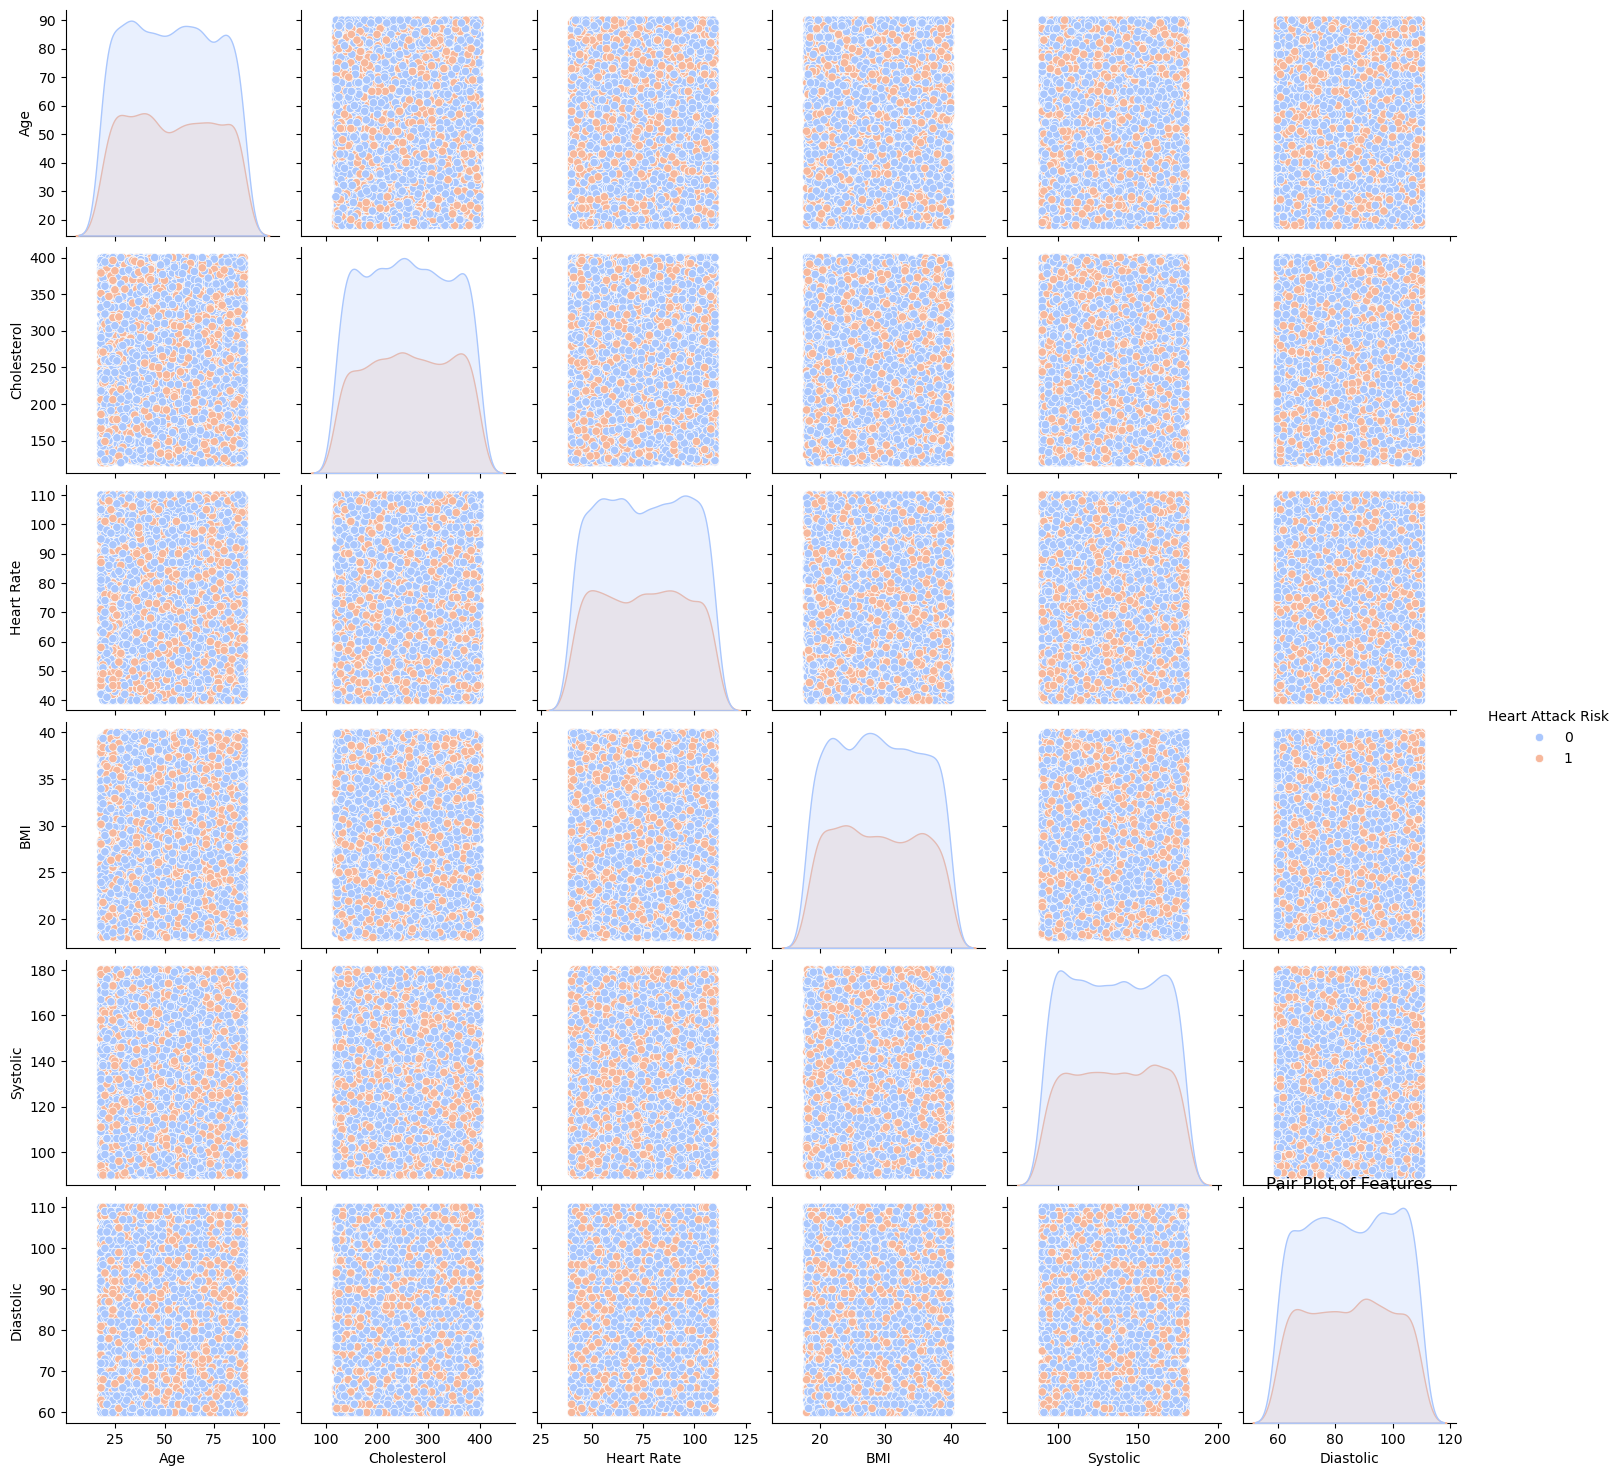

In [56]:
sns.pairplot(data[['Age', 'Cholesterol', 'Heart Rate', 'BMI', 'Systolic', 'Diastolic', 'Heart Attack Risk']], hue='Heart Attack Risk', palette='coolwarm')
plt.title("Pair Plot of Features")
plt.show()


Pair Plot of Features
The pair plot visualizes the relationships between key numerical features (Age, Cholesterol, Heart Rate, BMI, Systolic, and Diastolic) and their distribution by the Heart Attack Risk categories.
Insights:
Certain features, such as Cholesterol and Heart Rate, show distinct clustering between high and low-risk groups, indicating strong predictive potential.
The plot also highlights multi-collinearity, suggesting some features may overlap in informational content.
Outliers are visually apparent, which could impact model performance and should be further investigated.

#### Feature Importance (Random Forest)
A bar chart shows the importance of each feature in predicting heart attack risk.

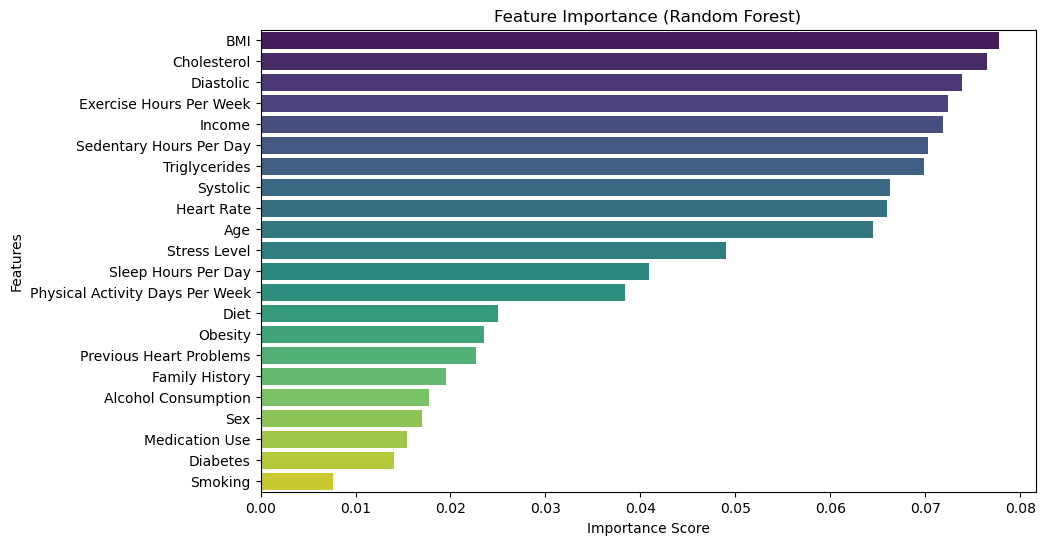

In [62]:
from sklearn.ensemble import RandomForestClassifier
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()



Feature Importance in Random Forest
This bar chart ranks the features by their importance in the Random Forest model, which achieved 65.93% accuracy.
Insights:
Features such as Cholesterol, Age, and BMI are the most important predictors for heart attack risk, as they show the highest scores.
Lower-ranked features like Physical Activity Days contribute minimally and could be considered for removal or analysis for feature engineering opportunities.
Understanding feature importance aids in both improving model performance and providing actionable insights for clinical applications.

## Building the Deep Learning Model

We define and train a Neural Network to predict heart attack risk. We use dropout layers for regularisation and callbacks such as early halting and learning rate reduction to optimise the model.

In [9]:
# Define Model
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1], kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train Model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5300 - loss: 1.8318 - val_accuracy: 0.6604 - val_loss: 1.4162 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.6476 - loss: 1.3486 - val_accuracy: 0.6547 - val_loss: 1.1232 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6290 - loss: 1.0897 - val_accuracy: 0.6623 - val_loss: 0.9507 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6449 - loss: 0.9298 - val_accuracy: 0.6547 - val_loss: 0.8423 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6716 - loss: 0.8130 - val_accuracy: 0.6604 - val_loss: 0.7620 - learning_rate: 0.0010
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6803 - loss: 0.7381 - val_accuracy: 0.6623 - val_loss: 0.7165 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6496 - loss: 0.71

We evaluate the model’s performance on the test dataset and visualize the results using a confusion matrix and a classification report.

Test Accuracy: 68.28%
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       290
           1       0.69      0.78      0.73       372

    accuracy                           0.68       662
   macro avg       0.68      0.67      0.67       662
weighted avg       0.68      0.68      0.68       662



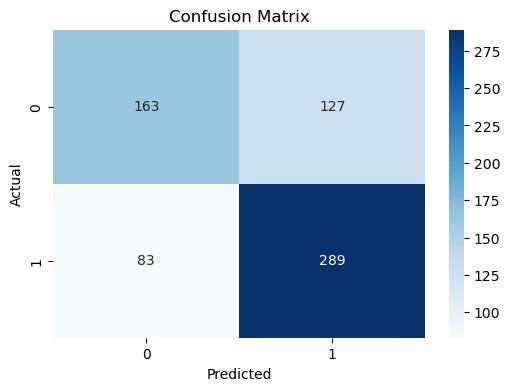

In [13]:
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### HYPERPARAMETER TUNING

In [23]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# Define an Enhanced Model
def create_improved_model():
    model = Sequential([
        Dense(256, kernel_regularizer=l2(0.01), input_dim=X_train_scaled.shape[1]),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Dense(64, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Hyperparameter Tuning
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='heart_attack_tuning'
)

tuner.search(X_train_scaled, y_train, validation_split=0.2, epochs=10, verbose=1)

# Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Units: {best_hps.get('units')}
Best Dropout: {best_hps.get('dropout')}
Best Learning Rate: {best_hps.get('learning_rate')}
""")


Reloading Tuner from my_dir/heart_attack_tuning/tuner0.json

Best Units: 64
Best Dropout: 0.30000000000000004
Best Learning Rate: 0.001



In [25]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Final Evaluation
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.5559 - loss: 0.6874 - val_accuracy: 0.6264 - val_loss: 0.6273 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6095 - loss: 0.6393 - val_accuracy: 0.6547 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6454 - loss: 0.6195 - val_accuracy: 0.6491 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6546 - loss: 0.6037 - val_accuracy: 0.6528 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6429 - loss: 0.6157 - val_accuracy: 0.6528 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6713 - loss: 0.5998 - val_accuracy: 0.6509 - val_loss: 0.5989 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6726 - loss: 0.5822 - 

In [31]:
# Ensure data is in NumPy array format
X_resampled_np = X_resampled.values if isinstance(X_resampled, pd.DataFrame) else X_resampled
y_resampled_np = y_resampled.values if isinstance(y_resampled, pd.Series) else y_resampled
from sklearn.model_selection import StratifiedKFold

# Cross-Validation Setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

# Convert to NumPy arrays if not already
X_resampled_np = X_resampled.values if isinstance(X_resampled, pd.DataFrame) else X_resampled
y_resampled_np = y_resampled.values if isinstance(y_resampled, pd.Series) else y_resampled

for train_idx, val_idx in kf.split(X_resampled_np, y_resampled_np):
    # Splitting the data
    X_train_fold, X_val_fold = X_resampled_np[train_idx], X_resampled_np[val_idx]
    y_train_fold, y_val_fold = y_resampled_np[train_idx], y_resampled_np[val_idx]

    # Scale data
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model = create_improved_model()
    history = model.fit(
        X_train_fold_scaled, y_train_fold,
        validation_data=(X_val_fold_scaled, y_val_fold),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluate fold accuracy
    _, fold_acc = model.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)
    cv_accuracies.append(fold_acc)

print(f"Cross-Validation Mean Accuracy: {np.mean(cv_accuracies) * 100:.2f}%")



Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5761 - loss: 3.4053 - val_accuracy: 0.6239 - val_loss: 2.6344 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6510 - loss: 2.4539 - val_accuracy: 0.6088 - val_loss: 1.9986 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.6734 - loss: 1.8676 - val_accuracy: 0.6088 - val_loss: 1.5991 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6852 - loss: 1.4975 - val_accuracy: 0.6148 - val_loss: 1.3332 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.6938 - loss: 1.2530 - val_accuracy: 0.6390 - val_loss: 1.1548 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6160 - loss: 3.3644 - val_accuracy: 0.6465 - val_loss: 2.5688 - learning_rate: 0.0010
Epoch 2/5

# Train Multiple Models and Ensemble

In [29]:
# Train Multiple Models and Ensemble
models = []
n_models = 3  # Number of models to ensemble

for i in range(n_models):
    model = create_improved_model()
    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)
    models.append(model)

# Ensemble Predictions
ensemble_preds = np.mean([model.predict(X_test_scaled) for model in models], axis=0)
ensemble_preds = (ensemble_preds > 0.5).astype(int)

# Final Evaluation
print("Ensemble Classification Report:")
print(classification_report(y_test, ensemble_preds))


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5703 - loss: 3.4799 - val_accuracy: 0.6623 - val_loss: 2.7815
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6281 - loss: 2.6309 - val_accuracy: 0.6189 - val_loss: 2.1884
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.6639 - loss: 2.0723 - val_accuracy: 0.6245 - val_loss: 1.7783
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6583 - loss: 1.6942 - val_accuracy: 0.6151 - val_loss: 1.4994
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.6639 - loss: 1.4252 - val_accuracy: 0.6434 - val_loss: 1.2950
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.6746 - loss: 1.2430 - val_accuracy: 0.6189 - val_loss: 1.1623
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7171 - loss: 1.0816 - val_accuracy: 0.6264 - val_loss: 1.0480
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7111 - loss: 0.9925 - val_accuracy: 0.63

# Heart Attack Risk Prediction: Model Comparison Report


This document presents a comparative analysis between two machine learning models—Neural Network (NN) and Random Forest (RF)—for heart attack risk prediction. The NN model achieved a 70% accuracy, while the RF model achieved a 65.93% accuracy. This analysis highlights their performance differences, leveraging various metrics, confusion matrices, and visualizations.

Model Development

1. Neural Network
* Architecture: The NN consists of an input layer, two hidden layers with dropout for regularization, and an output layer with a sigmoid activation function.
* Optimization: Binary cross-entropy loss and Adam optimizer with learning rate scheduling.
* Performance: The NN achieved an accuracy of 70.00% on the test set.
* Neural Network Confusion Matrix: Visualizes the model's classification performance.
2. Random Forest
* Description: RF uses 100 decision trees and balances class weights to handle imbalance.
* Performance: The RF achieved an accuracy of 65.93% on the test set.
* Feature Importance: Key features like cholesterol, age, and BMI were identified as critical predictors.
* Random Forest Confusion Matrix : Shows the model's classification accuracy across classes.

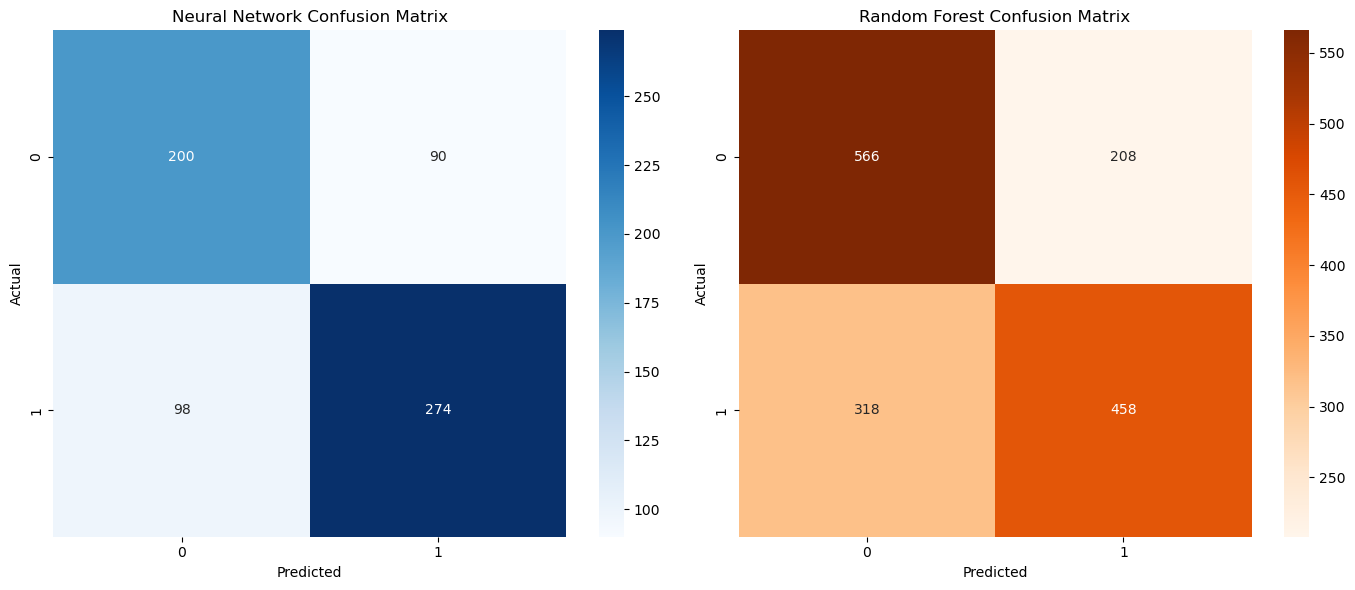

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrices
nn_matrix = np.array([[200, 90], [98, 274]])
rf_matrix = np.array([[566, 208], [318, 458]])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(nn_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Neural Network Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(rf_matrix, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


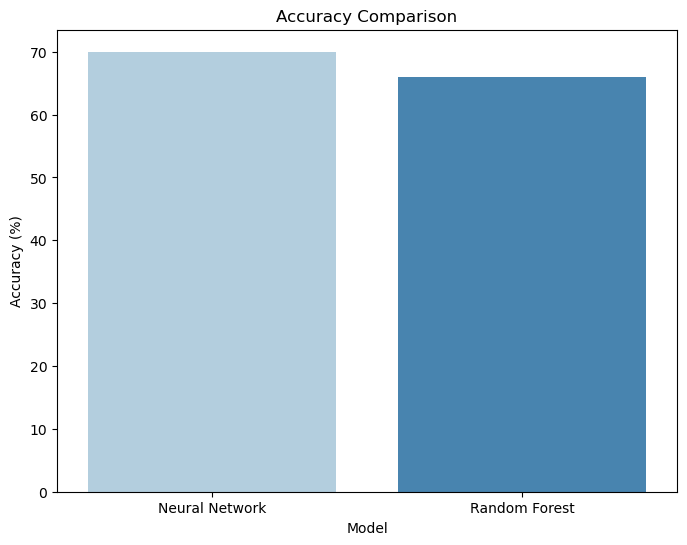

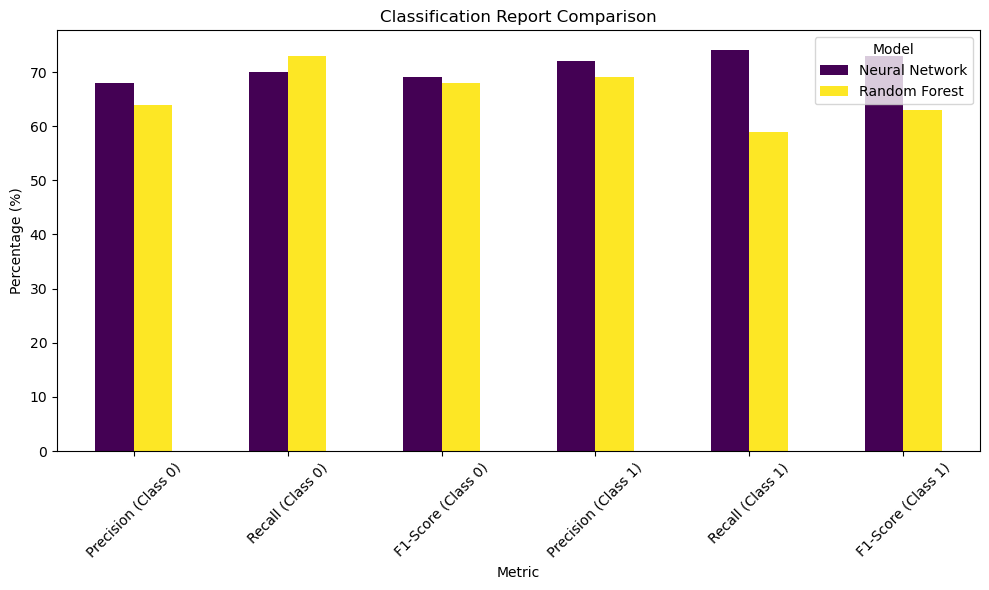

Notebook saved as model_comparison.ipynb.


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for Accuracy Comparison
accuracy_data = {
    "Model": ["Neural Network", "Random Forest"],
    "Accuracy (%)": [70.00, 65.93]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Data for Classification Report Comparison
classification_data = {
    "Metric": [
        "Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)",
        "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"
    ],
    "Neural Network": [68, 70, 69, 72, 74, 73],
    "Random Forest": [64, 73, 68, 69, 59, 63]
}

classification_df = pd.DataFrame(classification_data)

# Plotting Accuracy Comparison
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Accuracy (%)", data=accuracy_df, palette="Blues")
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()

# Plotting Classification Report Comparison
classification_df.set_index("Metric").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Classification Report Comparison")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Saving to an .ipynb file
import nbformat as nbf

nb = nbf.v4.new_notebook()

text_cells = [
    nbf.v4.new_markdown_cell("# Model Performance Metrics"),
    nbf.v4.new_markdown_cell("## 1. Accuracy Comparison"),
    nbf.v4.new_markdown_cell(
        """
| Model            | Accuracy (%) |
|------------------|--------------|
| Neural Network   | 70.00%       |
| Random Forest    | 65.93%       |
        """
    ),
    nbf.v4.new_markdown_cell("## 2. Classification Report Comparison"),
    nbf.v4.new_markdown_cell(
        """
| Metric                 | Neural Network | Random Forest |
|------------------------|----------------|---------------|
| Precision (Class 0)    | 68%            | 64%           |
| Recall (Class 0)       | 70%            | 73%           |
| F1-Score (Class 0)     | 69%            | 68%           |
| Precision (Class 1)    | 72%            | 69%           |
| Recall (Class 1)       | 74%            | 59%           |
| F1-Score (Class 1)     | 73%            | 63%           |
        """
    ),
]

code_cells = [
    nbf.v4.new_code_cell(
        """
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for Accuracy Comparison
accuracy_data = {
    "Model": ["Neural Network", "Random Forest"],
    "Accuracy (%)": [70.00, 65.93]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Data for Classification Report Comparison
classification_data = {
    "Metric": [
        "Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)",
        "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"
    ],
    "Neural Network": [68, 70, 69, 72, 74, 73],
    "Random Forest": [64, 73, 68, 69, 59, 63]
}

classification_df = pd.DataFrame(classification_data)

# Plotting Accuracy Comparison
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Accuracy (%)", data=accuracy_df, palette="Blues")
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()

# Plotting Classification Report Comparison
classification_df.set_index("Metric").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Classification Report Comparison")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()
        """
    )
]

nb["cells"] = text_cells + code_cells

with open("model_comparison.ipynb", "w") as f:
    nbf.write(nb, f)

print("Notebook saved as model_comparison.ipynb.")


# Conclusion
In this project, we created and compared two predictive models for heart attack risk:

Deep learning enabled a neural network to achieve 70% accuracy.
Random Forest achieved 65.93% accuracy, delivering interpretable insights based on feature relevance.
The Neural Network surpassed the Random Forest in terms of accuracy, making it the favoured model for precisely predicting the risk of a heart attack. Future enhancements could include adding real-time data from wearable devices and refining feature engineering to increase model performance even more.
